# Primer set


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Abrimos y ajustamos los datos para leerlos
datos_pacientes = pd.read_csv("Datos.csv",sep = ";")
datos_pacientes["Marca de tiempo"] = pd.to_datetime(datos_pacientes["Marca de tiempo"])
datos_operaciones = pd.read_csv("Datos operaciones origen urgencias.csv")

datos_operaciones = datos_operaciones.iloc[:,:5]
datos_operaciones = datos_operaciones.drop(datos_operaciones.columns[3],axis = 1)

In [20]:
#Estas son las áreas que aparecen en el diagrama entregado
areas_mapa_profe = ["URG101_003","DIV101_603","DIV101_604","DIV101_703","DIV102_203","DIV103_107","DIV103_204",
"DIV104_602","OPR101_011","OPR101_033","OPR102_001","OPR102_003","End"]

In [21]:
# Lo primero que haremos será filtrar los datos para obtener el nodo "Outisde"
filtro_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))
datos_pacientes.loc[filtro_fuera,"Area"] = "Outside"

In [22]:
#Eliminamos las filas donde el valor actual y el anterior corresponden al nodo outside, dejamos el primero,
#marcando así la entrada del paciente al nodo outside, pero solo una vez 
filtro_doble_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))&((~datos_pacientes["Area"].shift(1).isin(areas_mapa_profe)))
datos_pacientes = datos_pacientes[~filtro_doble_fuera]


In [23]:
datos_pacientes["Hora derivacion"] = datos_pacientes["Marca de tiempo"].shift(-1)
datos_pacientes["Estadia"] = datos_pacientes["Hora derivacion"]  - datos_pacientes["Marca de tiempo"]
datos_pacientes["Estadia"] = datos_pacientes["Estadia"]/np.timedelta64(1,"h")
datos_pacientes["Siguiente Área"] = datos_pacientes["Area"].shift(-1)

In [24]:
import pylab as pl

In [25]:
plt.style.use('ggplot')

Probabilidad de transición desde la sala de urgencias (Outside)
End           71.238938
OPR102_003     8.185841
OPR102_001     6.194690
DIV104_602     3.539823
DIV103_204     2.876106
DIV101_603     2.654867
DIV101_604     2.433628
OPR101_033     1.327434
DIV102_203     0.884956
DIV103_107     0.442478
DIV101_703     0.221239
Name: Siguiente Área, dtype: float64


Text(0.5, 0, 'Horas')

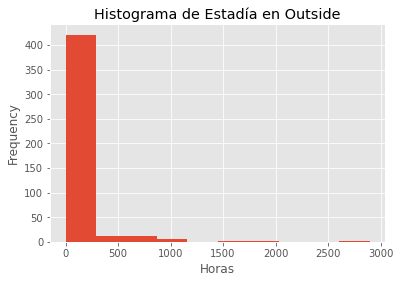

In [26]:
area = "Outside"
derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
print(f"Probabilidad de transición desde la sala de urgencias ({area})")
transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
print(transiciones)
estadia_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
hist = estadia_urgencia.plot.hist(title = f"Histograma de Estadía en {area}")
hist.set_xlabel("Horas")

# Analizamos caso a a caso

In [41]:
set_pacientes = set(datos_pacientes["Case ID"])
entrada = "URG101_003"
salida = "End"
dic_info_pacientes = dict.fromkeys(set_pacientes,{})
for paciente in set_pacientes:
    info_paciente = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    hora_entrada = info_paciente.iloc[0]["Marca de tiempo"]
    hora_salida = info_paciente.iloc[-1]["Marca de tiempo"]
    dic_paciente ={"Entrada":hora_entrada,"Salida":hora_salida}
    duracion = hora_salida - hora_entrada
    dic_paciente["Duracion"] = duracion/np.timedelta64(1,"h")
    procedimiento = list(info_paciente["Area"])
    ruta = "".join(procedimiento)
    dic_paciente["Ruta"] = ruta
    dic_info_pacientes[paciente] = dic_paciente
    

In [46]:
df_info_pacientes = pd.DataFrame(dic_info_pacientes).T


,Entrada,Salida,Duracion,Ruta
14817280,2018-03-30 18:14:00,2018-03-30 22:06:00,3.86667,URG101_003DIV101_703DIV103_204End
14931970,2018-05-13 16:37:00,2018-05-14 00:14:00,7.61667,URG101_003DIV101_703DIV102_203OPR102_001OPR101...
14888963,2018-04-25 16:06:00,2018-04-26 12:26:00,20.3333,URG101_003DIV101_703OutsideEnd
14696460,2018-02-15 12:04:00,2018-02-16 15:55:00,27.85,URG101_003DIV101_703DIV101_604End
14579725,2018-01-04 21:05:00,2018-01-04 22:46:00,1.68333,URG101_003DIV101_703End
...,...,...,...,...
14888950,2018-04-25 17:31:00,2018-05-15 14:18:00,476.783,URG101_003DIV101_703OutsideDIV101_603End
14682104,2018-02-08 14:27:00,2018-02-09 13:53:00,23.4333,URG101_003DIV101_703DIV104_602End
14716923,2018-02-23 10:13:00,2018-02-23 18:39:00,8.43333,URG101_003DIV101_703End
14716925,2018-02-23 17:47:00,2018-02-24 14:22:00,20.5833,URG101_003DIV101_703OutsideEnd


# Obtenemos el estado actual de los KPI

### Lead time promedio

In [48]:
df_info_pacientes["Duracion"].mean()

81.9152056901192

### 5% de peores casos

In [63]:
duraciones = df_info_pacientes["Duracion"].sort_values()
n_5_peor = int(duraciones.shape[0]*0.05)
pct_5_peores_casos = duraciones.iloc[-n_5_peor:]
print(pct_5_peores_casos.mean())
print(pct_5_peores_casos.min())
print(pct_5_peores_casos.max())

971.1093023255813
453.93333333333334
4517.7


# Analizamos las llegadas

### Histograma de llegadas(solo para llegadas en menos de 24 horas)

Text(0.5, 1.0, 'Tiempo entre llegadas (Para tiempos menores a 24 horas)')

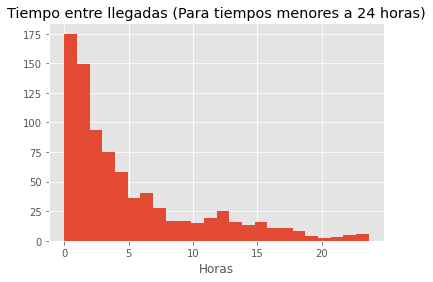

In [113]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
hist = tiempo_entre_llegadas[tiempo_entre_llegadas < 24].hist(bins = 24)
hist.set_xlabel("Horas")
hist.set_title("Tiempo entre llegadas (Para tiempos menores a 24 horas)")

Text(0.5, 0, 'Hora del día')

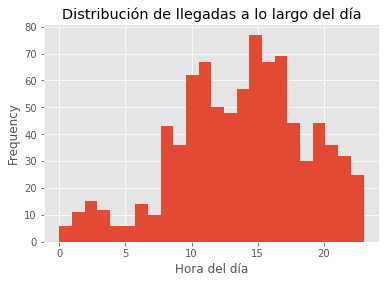

In [114]:
horas_entrada = [entrada.hour for entrada in df_info_pacientes["Entrada"]]
df_info_pacientes["Hora entrada"] = horas_entrada
hist = df_info_pacientes["Hora entrada"].plot.hist(bins = 24,title = "Distribución de llegadas a lo largo del día")
hist.set_xlabel("Hora del día")

# Segundo set  (Operaciones)

In [133]:
print(datos_operaciones["DURACION (hrs)"].mean())
print(datos_operaciones["DURACION (hrs)"].max())
print(datos_operaciones["DURACION (hrs)"].min())

2.4310679611650485
4.1
0.0


Text(0.5, 0, 'Horas')

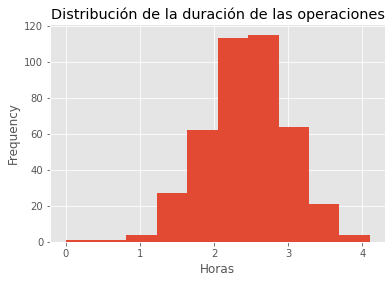

In [135]:
hist = datos_operaciones["DURACION (hrs)"].plot.hist()
hist.set_title("Distribución de la duración de las operaciones")
hist.set_xlabel("Horas")

Text(0.5, 1.0, 'Cantidad de operaciones recibidas por paciente')

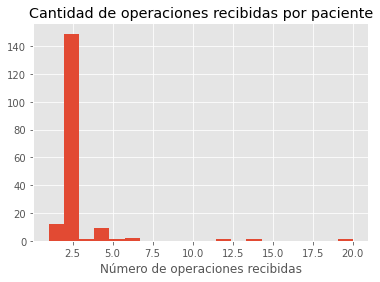

In [129]:
hist = datos_operaciones["ID"].value_counts().hist(bins = 20)
hist.set_xlabel("Número de operaciones recibidas")
hist.set_title("Cantidad de operaciones recibidas por paciente")

Text(0, 0.5, 'Número de operaciones realizadas')

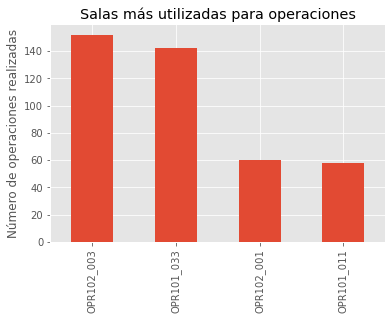

In [128]:
barplot = datos_operaciones["SALA OPERACIONES"].value_counts().plot.bar()
barplot.set_title("Salas más utilizadas para operaciones")
barplot.set_ylabel("Número de operaciones realizadas")

In [130]:
datos_operaciones

,ID,SALA OPERACIONES,FECHA E INICIO,DURACION (hrs)
0,14548704,OPR101_011,2018-01-02 10:15:00.000,2.8
1,14557024,OPR101_011,2017-12-22 13:37:00.000,1.6
2,14557024,OPR101_011,2018-01-12 15:36:00.000,1.2
3,14562339,OPR101_011,2018-01-03 15:56:00.000,1.3
4,14568735,OPR101_011,2018-01-05 18:34:00.000,3.2
...,...,...,...,...
407,14775043000,OPR102_003,2018-03-15 15:17:00.000,2.4
408,14799531000,OPR102_003,2018-03-26 13:02:00.000,3.3
409,14867095000,OPR102_003,2018-04-17 18:25:00.000,3.4
410,14973437000,OPR102_003,2018-05-30 13:42:00.000,2.4
